In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from functools import partial
from scipy.integrate import simpson

import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import cmasher as cmr
%matplotlib inline

# import time

machine_eps = np.finfo("float32").eps

In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
def integral(y, x):
    '''
    Definite integral of y with respect to x.
    See https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simpson.html.
    Used as a helper function.
    '''
    return simpson(y, x, axis = 0)

In [4]:
def random_mat_cor(mat_cor_cor, P, n_beta, n_c, key):
    '''
    Generate random P x P correlation matrices.
    
    Inputs
    ------
    P (int):
        Size of the correlation matrix.
    mat_cor_cor (float):
        Correlation matrices of the noise in the correlation matrices
    key (int):
        Seed of random number generation.
    
    Outputs
    -------
    mat_cor (float array):
        Correlation matrices.
    '''
    # Generate random symmetric positive definite matrices from the Wishart distribution with covariance matrix mat_cor_cor
    A = jax.random.multivariate_normal(key, mean = jnp.zeros(P), cov = mat_cor_cor, shape = (n_beta, n_c, P))
    B = A @ jnp.transpose(A, axes = (0, 1, 3, 2))
    
    # Remove spurious negative values
    B = jnp.abs(B)
    
    # Normalize the diagonal elements to 1, i.e. find the corresponding correlation matrices
    D = jnp.diagonal(B, axis1 = -2, axis2 = -1)[..., jnp.newaxis]
    mat_cor = jnp.transpose(D, axes = (0, 1, 3, 2))**(-1/2) * B * D**(-1/2)
    
    return mat_cor

In [5]:
def mat_equi_cor(c, P):
    '''
    Generate an equicorrelation matrix.
    An equicorrelation matrix has diagonal entries equal to 1 and off-diagonal entries equal to a given number c.
    '''
    mat_cor = (1 - c) * jnp.eye(P, P) + c * jnp.ones((P, P))
    
    return mat_cor

In [6]:
def random_multivariate_binary(mat_cor, P, n_binary_samples, key):
    '''
    Generate binary random samples with mean 0 and a fixed covariance matrix mat_cor.
    This sampling method is commonly known as the arcsine law.
    Refer to the paper for a full reference.
    
    Inputs
    ------
    mat_cor (float array):
        Covariance matrix for random number generation.
    P (int):
        Size of the matrix.
    n_binary_samples (int):
        Number of random samples to generate.
    key (int):
        Seed of random number generation.
    
    Outputs
    -------
    spins_x (float array):
        Random samples generated.
    '''
    spins_x = jnp.sign(jax.random.multivariate_normal(key, mean = np.zeros(P), cov = np.sin(np.pi/2 * mat_cor), shape = (n_binary_samples,)))
    
    return spins_x

In [7]:
def init_spins(P, n_pre_appended_axes):
    
    spins_base = jnp.full((P, 2), jnp.array([-1, 1]))
    
    spins = jnp.reshape(jnp.array(jnp.meshgrid(*spins_base)).T, newshape = (-1,) + n_pre_appended_axes * (1,) + (P, 1))
    
    spins_T = jnp.transpose(spins, axes = tuple(range(spins.ndim-2)) + (spins.ndim-1,) + (spins.ndim-2,))
    
    return spins_T, spins

In [10]:
spins_T, spins = init_spins(3, 0)

print(spins_T)
print(spins)

print(spins_T.shape)
print(spins.shape)

[[[-1 -1 -1]]

 [[-1  1 -1]]

 [[ 1 -1 -1]]

 [[ 1  1 -1]]

 [[-1 -1  1]]

 [[-1  1  1]]

 [[ 1 -1  1]]

 [[ 1  1  1]]]
[[[-1]
  [-1]
  [-1]]

 [[-1]
  [ 1]
  [-1]]

 [[ 1]
  [-1]
  [-1]]

 [[ 1]
  [ 1]
  [-1]]

 [[-1]
  [-1]
  [ 1]]

 [[-1]
  [ 1]
  [ 1]]

 [[ 1]
  [-1]
  [ 1]]

 [[ 1]
  [ 1]
  [ 1]]]
(8, 1, 3)
(8, 3, 1)


In [8]:
def random_white_normal(n_normal_dims, n_normal_samples, key):
    z = jax.random.normal(key, shape = (n_normal_samples, n_normal_dims))
    z = (z - jnp.flip(z, axis = 0))/jnp.sqrt(2)
    
    C = jnp.array(jnp.cov(z, rowvar = False), ndmin = 2)
    
    # eigvals, eigvecs = jnp.linalg.eigh(C)
    # eigvecs, eigvals, _ = jnp.linalg.svd(C, hermitian = True)
    
    # z = ((z @ eigvecs) * 1/jnp.sqrt(eigvals)) @ eigvecs.T
    
    L = jnp.linalg.cholesky(C)
    z = jnp.linalg.solve(L, z.T).T
    
    return z

In [9]:
def random_sqrt_beta(n_sqrt_beta_dims, n_sqrt_beta_samples, key):
    key_beta, key_sign = jax.random.split(key, num = 2)
    
    u_square = jax.random.beta(key_beta, 1/2, (n_sqrt_beta_dims - 1)/2, shape = (n_sqrt_beta_samples, n_sqrt_beta_dims))
    # u_sign = jax.random.rademacher(key_sign, shape = (n_sqrt_beta_samples, n_sqrt_beta_dims))
    
    u = jnp.sqrt(u_square)
    # u = u_sign*jnp.sqrt(u_square)
    
    return u

In [10]:
def hamiltonian_M(spins_T, spins, mat_cor, beta):
    '''
    Evaluate the effective Hamiltonian M (or M_s) for the given input parameters.
    '''
    return 1/2*beta**2 * (spins_T @ mat_cor @ spins)
    
def probability(H):
    '''
    Evaluate the Gibbs distribution of some input energy levels.
    '''
    C = jnp.real(jnp.max(H, axis = 0))
    # C = jnp.max(H, axis = 0)
    M = jnp.exp(H - C)
    
    prob = M / jnp.sum(M, axis = 0)
    
    return prob

In [11]:
def keep_looping(t, tol, args):
    t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = args
    return (t_cur < t) & (jnp.sum((m_cur - m_prev)**2)/jnp.sum(m_cur**2) > tol)

In [12]:
class SymmetrizedIterator():
    '''
    Class for solving the saddle-point equations (Eqs. 3) via numerical iteration when the prior on the student patterns is the Rademacher distribution.
    This class uses the form of the third term of the effective Hamiltonian L presented at the end of Appendix A.4.
    The superscript (and subscript) * frequently used in the paper is replaced by _s in the code.
    The tilde frequently used in the paper is replaced by _t in the code.
    
    Attributes
    ----------
    mat_cor (float array):
        P x P covariance matrix of the teacher patterns.
    P (int):
        Size of the hidden layer of the teacher.
    P_t (int):
        Size of the hidden layer of the student.
    n_normal_samples (int):
        Number of normally distributed random samples used to approximate each integral over a Gaussian variable z_{mu nu}.
    n_binary_samples (int):
        Number of binary samples used to approximate the probability distribution of the teacher patterns.
    
    Methods
    -------
    update_params:
        Change the attributes beta_s, beta and alpha used by the iterator.
        Update the probability distribution p_M_s based on the new attributes.
    hamiltonian_L:
        Evaluate the effective Hamiltonian L for the given input parameters.
    update:
        Single iteration of the saddle-point equations.
        Update the conjugate order parameters first, then update the ordinary order parameters.
    iterate:
        Run update multiple times.
    '''
    def __init__(self, mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol):
        self.mat_cor = mat_cor
        self.P = P
        self.P_t = P_t
        
        self.spins_s_T, self.spins_s = init_spins(P, n_pre_appended_axes = 1)
        
        self.spins_T, self.spins = init_spins(P_t, n_pre_appended_axes = 2)
        
        key_off_diag, key_on_diag, key_binary, self.key_update = jax.random.split(key, num = 4)
        
        z_off_diag = random_white_normal(P_t*(P_t - 1)//2, n_normal_samples, key_off_diag)
        
        self.z_off_diag = jnp.zeros((n_normal_samples, P_t, P_t))
        self.z_off_diag = self.z_off_diag.at[:, jnp.tri(P_t, dtype = "bool", k = -1)].set(z_off_diag)
        self.z_off_diag = self.z_off_diag + jnp.transpose(self.z_off_diag, axes = (0, 2, 1))
        
        z_on_diag = random_white_normal(P_t, n_normal_samples, key_on_diag)
        
        self.z_on_diag = z_on_diag[:, jnp.newaxis]
        
        spins_x = random_multivariate_binary(mat_cor, P, n_binary_samples, key_binary).reshape(1, -1, P, 1)
        
        self.p_x = jnp.mean(jnp.all(self.spins_s == spins_x, axis = 2, keepdims = True), axis = 1, keepdims = True)
        
        self.tol = tol
    
    @partial(jax.jit, static_argnums = 0)
    def hamiltonian_L(self, m, s, q_on_diag, q_off_diag, lambda_1, lambda_2, key_update):
        
        q_sub = q_on_diag - jnp.sum(q_off_diag, axis = 1, keepdims = True)
        
        perm = jax.random.permutation(key_update, self.P_t)
        z_on_diag = self.z_on_diag[:, :, perm]
        z_off_diag = self.z_off_diag[:, perm[:, jnp.newaxis], perm]
        
        # z_on_diag = self.z_on_diag
        # z_off_diag = self.z_off_diag
        
        H_L = lambda_2 * (self.spins_T * z_on_diag) @ jnp.sqrt(q_sub + 0j)
        
        H_L = H_L + lambda_2 * (self.spins_T @ jnp.sum(z_off_diag * jnp.sqrt(q_off_diag + 0j), axis = -1, keepdims = True))
        
        H_L = H_L + 1/2*lambda_2**2 * (self.spins_T @ (s - q_off_diag) @ self.spins) + lambda_1*lambda_2 * (self.spins_s_T @ m @ self.spins)
        
        return H_L
    
    @partial(jax.jit, static_argnums = 0)
    def update(self, t_step, beta_s, beta, alpha, p_M_s, args):
        '''
        Inputs
        ------
        beta_s (float):
            Inverse temperature of the teacher.
        beta (float):
            Inverse temperature of the student.
        alpha (float):
            Normalized number of examples sent by the teacher to the student.
        '''
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = args
        
        m_prev = m_cur
        s_prev = s_cur
        q_prev = q_cur
        
        key_update, key_ordinary, key_conjugate = jax.random.split(key_update, num = 3)
        
        q_on_diag = jnp.diagonal(q_cur).copy()[:, jnp.newaxis]
        q_off_diag = q_cur - jnp.eye(self.P_t, self.P_t) * q_on_diag
        
        H_L = self.hamiltonian_L(m_cur, s_cur, q_on_diag, q_off_diag, beta_s, beta, key_ordinary)
        p_L = jnp.real(probability(H_L))
        
        # jax.debug.print("{p_L}", p_L = jnp.max(jnp.sum(jnp.abs(p_L), axis = 0)))
        
        H_M = hamiltonian_M(self.spins_T, self.spins, s_cur, beta)
        p_M = probability(H_M)
        
        m_hat = (1 - t_step) * m_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(self.spins_s * jnp.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_hat = (1 - t_step) * s_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(jnp.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0) - jnp.sum(p_M * self.spins_T * self.spins, axis = 0))
        q_hat = (1 - t_step) * q_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(jnp.sum(p_L * self.spins_T, axis = 0) * jnp.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        q_on_diag = jnp.diagonal(q_hat).copy()[:, jnp.newaxis]
        q_off_diag = q_hat - jnp.eye(self.P_t, self.P_t) * q_on_diag
        
        H_L = self.hamiltonian_L(m_hat, s_hat, q_on_diag, q_off_diag, 1, 1, key_conjugate)
        p_L = jnp.real(probability(H_L))
        
        # jax.debug.print("{p_L}", p_L = jnp.max(jnp.sum(jnp.abs(p_L), axis = 0)))
        
        m_cur = (1 - t_step) * m_cur + t_step * jnp.squeeze(jnp.sum(self.p_x * jnp.mean(self.spins_s * jnp.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_cur = (1 - t_step) * s_cur + t_step * jnp.squeeze(jnp.sum(self.p_x * jnp.mean(jnp.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        q_cur = (1 - t_step) * q_cur + t_step * jnp.squeeze(jnp.sum(self.p_x * jnp.mean(jnp.sum(p_L * self.spins_T, axis = 0) * jnp.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        t_cur = t_cur + 1
        
        return t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, key_update
    
    @partial(jax.jit, static_argnums = (0, 1))
    def iterate(self, t, t_step, beta_s, beta, alpha, m, s, q):
        
        H_M_s = hamiltonian_M(self.spins_s_T, self.spins_s, self.mat_cor, beta_s)
        p_M_s = probability(H_M_s)
        
        # Symmetrize q before the first iteration as explained in the text.
        q = (q + q.T)/2
        
        # start = time.time()
        
        jax.debug.print("End.")
        
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = self.update(1, beta_s, beta, alpha, p_M_s,
                                                                                                          (0, m, s, q, m, s, q, m, s, q, self.key_update))
        
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = jax.lax.while_loop(partial(keep_looping, t, self.tol),
                                                                                                                 partial(self.update, t_step,
                                                                                                                         beta_s, beta, alpha, p_M_s),
                                                                                                                 (t_cur, m_cur, s_cur, q_cur, m_prev,
                                                                                                                  s_prev, q_prev, m_hat, s_hat, q_hat, key_update))
        
        jax.debug.print("Begin:")
        
        # jax.debug.print("{q_cur}", q_cur = q_cur)
        
        # end = time.time()
        # print("Timing:")
        # print(end - start)
        
        return m_cur, s_cur, q_cur, p_M_s

In [13]:
class Iterator():
    '''
    Class for solving the saddle-point equations (Eqs. 3) via numerical iteration when the prior on the student patterns is the Rademacher distribution.
    The superscript (and subscript) * frequently used in the paper is replaced by _s in the code.
    The tilde frequently used in the paper is replaced by _t in the code.
    
    Attributes
    ----------
    mat_cor (float array):
        P x P covariance matrix of the teacher patterns.
    P (int):
        Size of the hidden layer of the teacher.
    P_t (int):
        Size of the hidden layer of the student.
    n_normal_samples (int):
        Number of normally distributed random samples used to approximate each integral over a Gaussian variable z_{mu nu}.
    n_binary_samples (int):
        Number of binary samples used to approximate the probability distribution of the teacher patterns.
    
    Methods
    -------
    update_params:
        Change the attributes beta_s, beta and alpha used by the iterator.
        Update the probability distribution p_M_s based on the new attributes.
    hamiltonian_L:
        Evaluate the effective Hamiltonian L for the given input parameters.
    update:
        Single iteration of the saddle-point equations.
        Update the conjugate order parameters first, then update the ordinary order parameters.
    iterate:
        Run update multiple times.
    '''
    def __init__(self, mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol):
        self.mat_cor = mat_cor
        self.P = P
        self.P_t = P_t
        
        self.spins_s_T, self.spins_s = init_spins(P, n_pre_appended_axes = 1)
        
        self.spins_T, self.spins = init_spins(P_t, n_pre_appended_axes = 2)
        
        key_normal, key_binary, self.key_update = jax.random.split(key, num = 3)
        
        z = random_white_normal(P_t**2, n_normal_samples, key_normal)
        self.z = jnp.reshape(z, newshape = (-1, P_t, P_t))
        
        spins_x = random_multivariate_binary(mat_cor, P, n_binary_samples, key_binary).reshape(1, -1, P, 1)
        
        self.p_x = jnp.mean(jnp.all(self.spins_s == spins_x, axis = 2, keepdims = True), axis = 1, keepdims = True)
        
        self.tol = tol
    
    @partial(jax.jit, static_argnums = 0)
    def hamiltonian_L(self, m, s, q, lambda_1, lambda_2, key_update):
        
        perm = jax.random.permutation(key_update, self.P_t)
        z = self.z[:, perm[:, jnp.newaxis], perm]
        
        # z = self.z
        
        A_q_times_z = jnp.sqrt(2*q - jnp.diag(jnp.sum(q, axis = 1) + 0j)) * z
        
        H_L = lambda_2 * (jnp.sum(self.spins_T @ A_q_times_z, axis = -1, keepdims = True) + jnp.sum(A_q_times_z @ self.spins, axis = -2, keepdims = True))/2
        
        q_off_diag = q.at[jnp.diag_indices_from(q)].set(0)
        
        H_L = H_L + 1/2*lambda_2**2 * (self.spins_T @ (s - q_off_diag) @ self.spins)
        
        H_L = H_L + lambda_1*lambda_2 * (self.spins_s_T @ m @ self.spins)
        
        return H_L
    
    @partial(jax.jit, static_argnums = 0)
    def update(self, t_step, beta_s, beta, alpha, p_M_s, args):
        '''
        Inputs
        ------
        beta_s (float):
            Inverse temperature of the teacher.
        beta (float):
            Inverse temperature of the student.
        alpha (float):
            Normalized number of examples sent by the teacher to the student.
        '''
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = args
        
        m_prev = m_cur
        s_prev = s_cur
        q_prev = q_cur
        
        key_update, key_ordinary, key_conjugate = jax.random.split(key_update, num = 3)
        
        H_L = self.hamiltonian_L(m_cur, s_cur, q_cur, beta_s, beta, key_ordinary)
        p_L = jnp.real(probability(H_L))
        
        # jax.debug.print("{p_L}", p_L = jnp.max(jnp.sum(jnp.abs(p_L), axis = 0)))
        
        H_M = hamiltonian_M(self.spins_T, self.spins, s_cur, beta)
        p_M = probability(H_M)
        
        m_hat = (1 - t_step) * m_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(self.spins_s * jnp.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_hat = (1 - t_step) * s_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(jnp.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0) - jnp.sum(p_M * self.spins_T * self.spins, axis = 0))
        q_hat = (1 - t_step) * q_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(jnp.sum(p_L * self.spins_T, axis = 0) * jnp.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        H_L = self.hamiltonian_L(m_hat, s_hat, q_hat, 1, 1, key_conjugate)
        p_L = jnp.real(probability(H_L))
        
        # jax.debug.print("{p_L}", p_L = jnp.max(jnp.sum(jnp.abs(p_L), axis = 0)))
        
        m_cur = (1 - t_step) * m_cur + t_step * jnp.squeeze(jnp.sum(self.p_x * jnp.mean(self.spins_s * jnp.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_cur = (1 - t_step) * s_cur + t_step * jnp.squeeze(jnp.sum(self.p_x * jnp.mean(jnp.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        q_cur = (1 - t_step) * q_cur + t_step * jnp.squeeze(jnp.sum(self.p_x * jnp.mean(jnp.sum(p_L * self.spins_T, axis = 0) * jnp.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        
        t_cur = t_cur + 1
        
        return t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update
    
    @partial(jax.jit, static_argnums = (0, 1))
    def iterate(self, t, t_step, beta_s, beta, alpha, m, s, q):
        
        H_M_s = hamiltonian_M(self.spins_s_T, self.spins_s, self.mat_cor, beta_s)
        p_M_s = probability(H_M_s)
        
        # Symmetrize q before the first iteration as explained in the text.
        q = (q + q.T)/2
        
        # start = time.time()
        
        # jax.debug.print("End.")
        
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = self.update(1, beta_s, beta, alpha, p_M_s,
                                                                                                          (0, m, s, q, m, s, q, m, s, q, self.key_update))
        
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = jax.lax.while_loop(partial(keep_looping, t, self.tol),
                                                                                                                 partial(self.update, t_step,
                                                                                                                         beta_s, beta, alpha, p_M_s),
                                                                                                                 (t_cur, m_cur, s_cur, q_cur, m_prev,
                                                                                                                  s_prev, q_prev, m_hat, s_hat, q_hat, key_update))
        
        # jax.debug.print("Begin:")
        
        # jax.debug.print("{q_cur}", q_cur = q_cur)
        
        # end = time.time()
        # print("Timing:")
        # print(end - start)
        
        return m_cur, s_cur, q_cur, p_M_s

In [14]:
class NormalIterator():
    '''
    Class for solving the saddle-point equations (Eqs. 3) via numerical iteration when the prior on the student patterns is the standard normal distribution.
    The superscript (and subscript) * frequently used in the paper is replaced by _s in the code.
    The tilde frequently used in the paper is replaced by _t in the code.
    
    Attributes
    ----------
    mat_cor (float array):
        P x P covariance matrix of the teacher patterns.
    P (int):
        Size of the hidden layer of the teacher.
    P_t (int):
        Size of the hidden layer of the student.
    n_normal_samples (int):
        Number of normally distributed random samples used to approximate each integral over a Gaussian variable z_{mu nu}.
    n_binary_samples (int):
        Number of binary samples used to approximate the probability distribution of the teacher patterns.
    
    Methods
    -------
    update_params:
        Change the attributes beta_s, beta and alpha used by the iterator.
        Update the probability distribution p_M_s based on the new attributes.
    hamiltonian_L:
        Evaluate the effective Hamiltonian L for the given input parameters.
    update:
        Single iteration of the saddle-point equations.
        Update the conjugate order parameters first, then update the ordinary order parameters.
    iterate:
        Run update multiple times.
    '''
    def __init__(self, mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol):
        self.mat_cor = mat_cor
        self.P = P
        self.P_t = P_t
        
        self.spins_s_T, self.spins_s = init_spins(P, n_pre_appended_axes = 1)
        
        self.spins_T, self.spins = init_spins(P_t, n_pre_appended_axes = 2)
        
        key_normal, key_binary, self.key_update = jax.random.split(key, num = 3)
        
        z = random_white_normal(P_t**2, n_normal_samples, key_normal)
        self.z = jnp.reshape(z, newshape = (-1, P_t, P_t))
        
        self.teacher_mat_cor = mat_cor
        
        self.tol = tol
    
    @partial(jax.jit, static_argnums = 0)
    def hamiltonian_L(self, m, s, q, lambda_1, lambda_2, key_update):
        
        perm = jax.random.permutation(key_update, self.P_t)
        z = self.z[:, perm[:, jnp.newaxis], perm]
        
        # z = self.z
        
        A_q_times_z = jnp.sqrt(2*q - jnp.diag(jnp.sum(q, axis = 1) + 0j)) * z
        
        H_L = lambda_2 * (jnp.sum(self.spins_T @ A_q_times_z, axis = -1, keepdims = True) + jnp.sum(A_q_times_z @ self.spins, axis = -2, keepdims = True))/2
        
        # q_off_diag = q.at[jnp.diag_indices_from(q)].set(0)
        
        H_L = H_L + 1/2*lambda_2**2 * (self.spins_T @ (s - q) @ self.spins)
        
        H_L = H_L + lambda_1*lambda_2 * (self.spins_s_T @ m @ self.spins)
        
        return H_L
    
    @partial(jax.jit, static_argnums = 0)
    def update(self, t_step, beta_s, beta, alpha, p_M_s, args):
        '''
        Inputs
        ------
        beta_s (float):
            Inverse temperature of the teacher.
        beta (float):
            Inverse temperature of the student.
        alpha (float):
            Normalized number of examples sent by the teacher to the student.
        '''
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = args
        
        m_prev = m_cur
        s_prev = s_cur
        q_prev = q_cur
        
        key_update, key_ordinary, key_conjugate = jax.random.split(key_update, num = 3)
        
        H_L = self.hamiltonian_L(m_cur, s_cur, q_cur, beta_s, beta, key_ordinary)
        p_L = jnp.real(probability(H_L))
        
        # jax.debug.print("{p_L}", p_L = jnp.max(jnp.sum(jnp.abs(p_L), axis = 0)))
        
        H_M = hamiltonian_M(self.spins_T, self.spins, s_cur, beta)
        p_M = probability(H_M)
        
        m_hat = (1 - t_step) * m_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(self.spins_s * jnp.sum(p_L * self.spins_T, axis = 0), axis = 1, keepdims = True), axis = 0))
        q_hat = (1 - t_step) * q_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(jnp.sum(p_L * self.spins_T, axis = 0) * jnp.sum(p_L * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0))
        s_hat = (1 - t_step) * s_hat + t_step * beta**2*alpha * jnp.squeeze(jnp.sum(p_M_s * jnp.mean(jnp.sum(p_L * self.spins_T * self.spins, axis = 0), axis = 1, keepdims = True), axis = 0) - jnp.sum(p_M * self.spins_T * self.spins, axis = 0))
        
        # H_L = self.hamiltonian_L(m_hat, s_hat, q_hat, 1, 1, key_conjugate)
        # p_L = jnp.real(probability(H_L))
        
        # jax.debug.print("{p_L}", p_L = jnp.max(jnp.sum(jnp.abs(p_L), axis = 0)))
        
        student_mat_cor = jnp.linalg.inv(jnp.eye(self.P_t) + q_hat - s_hat)
        
        m_id = m_hat @ student_mat_cor
        
        m_ext = self.teacher_mat_cor @ m_id
        q_ext = m_id.T @ m_ext + student_mat_cor @ q_hat @ student_mat_cor
        s_ext = q_ext + student_mat_cor
        
        m_cur = (1 - t_step) * m_cur + t_step * m_ext
        q_cur = (1 - t_step) * q_cur + t_step * q_ext
        s_cur = (1 - t_step) * s_cur + t_step * s_ext
        
        t_cur = t_cur + 1
        
        return t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update
    
    @partial(jax.jit, static_argnums = (0, 1))
    def iterate(self, t, t_step, beta_s, beta, alpha, m, s, q):
        
        H_M_s = hamiltonian_M(self.spins_s_T, self.spins_s, self.mat_cor, beta_s)
        p_M_s = probability(H_M_s)
        
        # Symmetrize q before the first iteration as explained in the text.
        q = (q + q.T)/2
        
        # start = time.time()
        
        # jax.debug.print("End.")
        
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = self.update(1, beta_s, beta, alpha, p_M_s,
                                                                                                          (0, m, s, q, m, s, q, m, s, q, self.key_update))
        
        t_cur, m_cur, s_cur, q_cur, m_prev, s_prev, q_prev, m_hat, s_hat, q_hat, key_update = jax.lax.while_loop(partial(keep_looping, t, self.tol),
                                                                                                                 partial(self.update, t_step,
                                                                                                                         beta_s, beta, alpha, p_M_s),
                                                                                                                 (t_cur, m_cur, s_cur, q_cur, m_prev,
                                                                                                                  s_prev, q_prev, m_hat, s_hat, q_hat, key_update))
        
        # jax.debug.print("Begin:")
        
        # jax.debug.print("{q_cur}", q_cur = q_cur)
        
        # end = time.time()
        # print("Timing:")
        # print(end - start)
        
        return m_cur, s_cur, q_cur, p_M_s

In [15]:
class SimpleIterator():
    def __init__(self, n_samples, n_stds = 5):
        self.z = np.linspace(-n_stds, n_stds, num = n_samples, endpoint = True)
    
    def update(self, beta, alpha, m, g):
        m_hat = beta**2*alpha * integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2)
                                         * np.tanh(beta**2 * m + beta * np.sqrt(m) * self.z), self.z)
    
        m = integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2) * np.tanh(m_hat + np.sqrt(m_hat) * self.z), self.z)
        
        g_hat = beta**2*alpha * integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2)
                                         * np.tanh(beta * np.sqrt(g) * self.z)**2, self.z)
    
        g = integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2) * np.tanh(np.sqrt(g_hat) * self.z)**2, self.z)
        
        return m, g
    
    def iterate(self, t, beta, alpha, m, g):
        
        for _ in range(t):
            m, g = self.update(beta, alpha, m, g)
        
        return m, g

In [16]:
class SimpleNormalIterator():
    def __init__(self, n_samples, n_stds = 5):
        self.z = np.linspace(-n_stds, n_stds, num = n_samples, endpoint = True)
    
    def update(self, beta, alpha, m, g):
        m_hat = beta**2*alpha * integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2)
                                         * np.tanh(beta**2 * m + beta * np.sqrt(m) * self.z), self.z)
    
        m = m_hat / (1 + m_hat)
        
        g_hat = beta**2*alpha * integral(1/np.sqrt(2*np.pi) * np.exp(-self.z**2/2)
                                         * np.tanh(beta * np.sqrt(g) * self.z)**2, self.z)
    
        g = g_hat / (1 + g_hat)**2
        
        return m, g
    
    def iterate(self, t, beta, alpha, m, g):
        
        for _ in range(t):
            m, g = self.update(beta, alpha, m, g)
        
        return m, g

In [17]:
def mat_cor_eigval(spins_s_T, spins_s, mat_cor_cor, beta_s_range, P, n_beta, n_c, key):
    mat_cor = random_mat_cor(mat_cor_cor, P, n_beta, n_c, key)
    
    # mat_cor: (n_c, 1, P, P) 
    
    # spins_s_T : (2**P, 1, 1, 1, P)
    # spins_s : (2**P, 1, 1, P, 1)
    
    H_M_s = hamiltonian_M(spins_s_T, spins_s, mat_cor, beta_s_range)
    p_M_s = probability(H_M_s)
    hidden_cor = jnp.sum(p_M_s * spins_s_T * spins_s, axis = 0)
    
    eigval = jnp.max(jnp.linalg.eigh(hidden_cor @ mat_cor)[0], axis = -1)
    
    return eigval

In [18]:
def accumulate_eigvals(spins_s_T, spins_s, mat_cor_cor, beta_s_range, P, n_beta, n_c, t_cur, args):
    mean_eigval, key = args
    key_init, key = jax.random.split(key, num = 2)
    
    eigval = mat_cor_eigval(spins_s_T, spins_s, mat_cor_cor, beta_s_range, P, n_beta, n_c, key_init)
    
    mean_eigval = mean_eigval + (eigval - mean_eigval) / (t_cur + 1)
    
    return mean_eigval, key

In [19]:
def accumulate_inv_eigvals(spins_s_T, spins_s, mat_cor_cor, beta_s_range, P, n_beta, n_c, t_cur, args):
    mean_inv_eigval, key = args
    key_init, key = jax.random.split(key, num = 2)
    
    eigval = mat_cor_eigval(spins_s_T, spins_s, mat_cor_cor, beta_s_range, P, n_beta, n_c, key_init)
    inv_eigval = 1/eigval
    
    # Iterative formula for the mean
    mean_inv_eigval = mean_inv_eigval + (inv_eigval - mean_inv_eigval) / (t_cur + 1)
    
    return mean_inv_eigval, key

In [36]:
def plot_overlap(beta, alpha_range, P_range, name):
    fig, (m_main_axes, m_res_axes) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = "row", figsize = (15, 6))
    m_fig_axis = fig.add_subplot(111, frameon = False)
    plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
    
    fig, (g_main_axes, g_res_axes) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = "row", figsize = (15, 6))
    g_fig_axis = fig.add_subplot(111, frameon = False)
    plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
    
    fontsize = 13
    
    set_ylabel = True
    for P, m_main_axis, m_res_axis, g_main_axis, g_res_axis in zip(P_range, m_main_axes, m_res_axes, g_main_axes, g_res_axes):
        with open("./Data/BM_%s_magnetization_P=%d_beta=%.2f.npy" % (name, P, beta), "rb") as file:
            m_comp_range = np.load(file)
            m_simp_range = np.load(file)
            print(m_comp_range[-1])
        
        with open("./Data/BM_%s_overlap_P=%d_beta=%.2f.npy" % (name, P, beta), "rb") as file:
            g_comp_range = np.load(file)
            g_simp_range = np.load(file)
        
        m_main_axis.plot(alpha_range, m_simp_range, linestyle = "-", color = "C0")
        m_main_axis.plot(alpha_range, m_comp_range, linestyle = "--", linewidth = 3, color = "C1")
        m_main_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        m_main_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        m_main_axis.legend([r"Simplified equations", r"Full equations with" + "\n" + r"$P = %d$ hidden units" % P], fontsize = fontsize)
        if set_ylabel:
            m_main_axis.set_ylabel(r"Magnetization $m$", fontsize = fontsize)
        
        if m_comp_range.ndim == m_simp_range.ndim + 1:
            m_simp_range = m_simp_range[:, np.newaxis]
        
        m_res_axis.plot(alpha_range, np.zeros_like(alpha_range), linestyle = "-", color = "C0")
        m_res_axis.plot(alpha_range, m_comp_range - m_simp_range, linestyle = "--", linewidth = 3, color = "C1")
        m_res_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        m_res_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        m_res_axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
        if set_ylabel:
            m_res_axis.set_ylabel(r"Residuals", fontsize = fontsize)
        
        g_main_axis.plot(alpha_range, g_simp_range, linestyle = "-", color = "C0")
        g_main_axis.plot(alpha_range, g_comp_range, linestyle = "--", linewidth = 3, color = "C3")
        g_main_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        g_main_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        g_main_axis.legend([r"Simplified equations", r"Full equations with" + "\n" + r"$P = %d$ hidden units" % P], fontsize = fontsize)
        if set_ylabel:
            g_main_axis.set_ylabel(r"Overlap $g$", fontsize = fontsize)
        
        if g_comp_range.ndim == g_simp_range.ndim + 1:
            g_simp_range = g_simp_range[:, np.newaxis]
        
        g_res_axis.plot(alpha_range, np.zeros_like(alpha_range), linestyle = "-", color = "C0")
        g_res_axis.plot(alpha_range, g_comp_range - g_simp_range, linestyle = "--", linewidth = 3, color = "C3")
        g_res_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        g_res_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        g_res_axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
        if set_ylabel:
            g_res_axis.set_ylabel(r"Residuals", fontsize = fontsize)
        
        set_ylabel = False
    
    m_fig_axis.set_xlabel(r"Load $\alpha$", fontsize = fontsize)
    g_fig_axis.set_xlabel(r"Load $\alpha$", fontsize = fontsize)
    plt.show()

In [ ]:
n_alpha = 20

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

m_comp_range = np.zeros(n_alpha)
m_simp_range = np.zeros(n_alpha)

g_comp_range = np.zeros(n_alpha)
g_simp_range = np.zeros(n_alpha)

n_normal_samples = 8000000
n_binary_samples = 80000000
n_simple_samples = 401
t = 100
t_step = 1/2
t_simple = 50
seed = 4
key = jax.random.PRNGKey(seed)
tol = machine_eps
m_0 = 0.1
epsilon = 0.02

beta_s = 1.2
beta = 1.2
alpha = 0
P = 2
P_t = 3
c = 0

mat_cor = mat_equi_cor(c, P)

iterator = Iterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

simple_iterator = SimpleIterator(n_simple_samples)

m_init = (m_0 - epsilon)*np.eye(P, P_t) + epsilon
s_init = (1 - epsilon)*np.eye(P_t) + epsilon
q_init = (m_0 - epsilon)*np.eye(P_t) + epsilon

m_simp_init = 0.1
g_simp_init = 0.1

for j, alpha in enumerate(alpha_range):
    m, s, q, _ = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
    print(m)
    print(q)
    m_comp_range[j] = np.mean(np.diagonal(m))
    if P_t > P:
        g_comp_range[j] = np.mean(np.diagonal(q)[P : P_t])
    
    m, g = simple_iterator.iterate(t_simple, beta, alpha, m_simp_init, g_simp_init)
    m_simp_range[j] = np.squeeze(m)
    if P_t > P:
        g_simp_range[j] = np.squeeze(g)

with open("./Data/BM_uncorrelated_magnetization_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, m_comp_range)
    np.save(file, m_simp_range)

with open("./Data/BM_uncorrelated_overlap_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, g_comp_range)
    np.save(file, g_simp_range)

In [ ]:
n_alpha = 20

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

beta = 1.2
P_range = np.array([2, 3])

fig, (m_main_axes, m_res_axes) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = "row", figsize = (15, 6))
m_fig_axis = fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)

fig, (g_main_axes, g_res_axes) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = "row", figsize = (15, 6))
g_fig_axis = fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)

fontsize = 13

set_ylabel = True
for P, m_main_axis, m_res_axis, g_main_axis, g_res_axis in zip(P_range, m_main_axes, m_res_axes, g_main_axes, g_res_axes):
    with open("./Data/BM_uncorrelated_magnetization_P=%d_beta=%.2f.npy" % (P, beta), "rb") as file:
        m_comp_range = np.load(file)
        m_comp_range = m_comp_range
        m_simp_range = np.load(file)
    
    with open("./Data/BM_uncorrelated_overlap_P=%d_beta=%.2f.npy" % (P, beta), "rb") as file:
        g_comp_range = np.load(file)
        g_simp_range = np.load(file)
    
    m_main_axis.plot(alpha_range, m_simp_range, linestyle = "-", color = "C0")
    m_main_axis.plot(alpha_range, m_comp_range, linestyle = "--", linewidth = 3, color = "C1")
    m_main_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    m_main_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    m_main_axis.legend([r"Simplified equations", r"Full equations with" + "\n" + r"$P = %d$ hidden units" % P], fontsize = fontsize)
    if set_ylabel:
        m_main_axis.set_ylabel(r"Magnetization $m$", fontsize = fontsize)
    
    m_res_axis.plot(alpha_range, np.zeros_like(alpha_range), linestyle = "-", color = "C0")
    m_res_axis.plot(alpha_range, m_comp_range - m_simp_range, linestyle = "--", linewidth = 3, color = "C1")
    m_res_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    m_res_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    m_res_axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
    if set_ylabel:
        m_res_axis.set_ylabel(r"Residuals", fontsize = fontsize)
    
    g_main_axis.plot(alpha_range, g_simp_range, linestyle = "-", color = "C0")
    g_main_axis.plot(alpha_range, g_comp_range, linestyle = "--", linewidth = 3, color = "C3")
    g_main_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    g_main_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    g_main_axis.legend([r"Simplified equations", r"Full equations with" + "\n" + r"$P = %d$ hidden units" % P], fontsize = fontsize)
    if set_ylabel:
        g_main_axis.set_ylabel(r"Overlap $g$", fontsize = fontsize)

    g_res_axis.plot(alpha_range, np.zeros_like(alpha_range), linestyle = "-", color = "C0")
    g_res_axis.plot(alpha_range, g_comp_range - g_simp_range, linestyle = "--", linewidth = 3, color = "C3")
    g_res_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    g_res_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    g_res_axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
    if set_ylabel:
        g_res_axis.set_ylabel(r"Residuals", fontsize = fontsize)
    
    set_ylabel = False

m_fig_axis.set_xlabel(r"Load $\alpha$", fontsize = fontsize)
g_fig_axis.set_xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.show()

In [33]:
n_alpha = 20

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

m_comp_range = np.zeros((n_alpha, 2))
m_simp_range = np.zeros(n_alpha)

g_comp_range = np.zeros((n_alpha, 2))
g_simp_range = np.zeros(n_alpha)

n_normal_samples = 8000000
n_binary_samples = 80000000
n_simple_samples = 401
t = 100
t_step = 1/2
t_simple = 50
seed = 4
key = jax.random.PRNGKey(seed)
tol = machine_eps
m_0 = 0.2
epsilon = 0

beta_s = 1.2
beta = 1.2
alpha = 0
P = 2
P_t = P + 1
c = 0

mat_cor = mat_equi_cor(c, P)

iterator = Iterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

simple_iterator = SimpleIterator(n_simple_samples)

m_init = (m_0 - epsilon)*np.eye(P, P_t) + epsilon
s_init = (1 - epsilon)*np.eye(P_t) + epsilon
m_init[0, P] = m_0
q_init = (m_0 - epsilon)*np.eye(P_t) + epsilon

m_simp_init = 0.1
g_simp_init = 0.1

for j, alpha in enumerate(alpha_range):
    m, s, q, _ = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
    
    m_comp_range[j, 0] = np.mean(np.diagonal(m)[1 :])
    m_comp_range[j, 1] = (m[0, 0] + m[0, P])/2
    if P_t > P:
        g_comp_range[j, 0] = (q[0, 0] + q[P_t, P_t])/2
        g_comp_range[j, 1] = (q[0, P_t] + q[P_t, 0])/2
    
    m, g = simple_iterator.iterate(t_simple, beta, alpha, m_simp_init, g_simp_init)
    m_simp_range[j] = np.squeeze(m)
    if P_t > P:
        g_simp_range[j] = np.squeeze(g)

with open("./Data/BM_unstructured_magnetization_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, m_comp_range)
    np.save(file, m_simp_range)

with open("./Data/BM_unstructured_overlap_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, g_comp_range)
    np.save(file, g_simp_range)

[[4.4702584e-01 7.7601071e-05 4.4654450e-01]
 [4.0245588e-05 6.7598975e-01 7.8658530e-05]]
[[4.8331773e-01 2.9118801e-05 1.9641736e-01]
 [2.9118801e-05 6.7603636e-01 6.8683097e-05]
 [1.9641736e-01 6.8683097e-05 4.8300374e-01]]


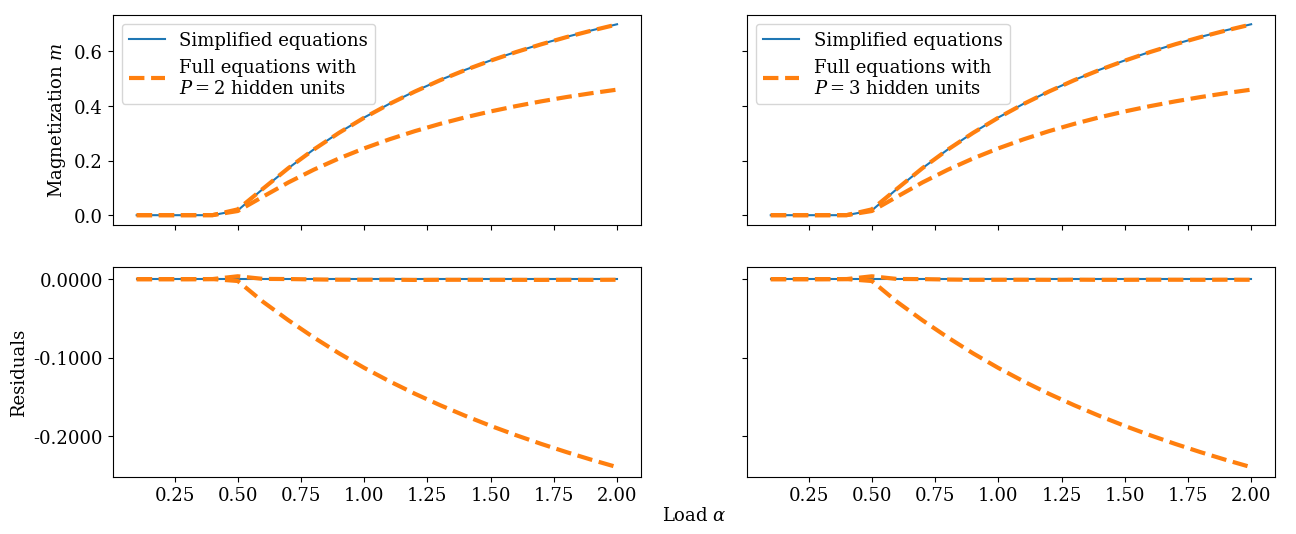

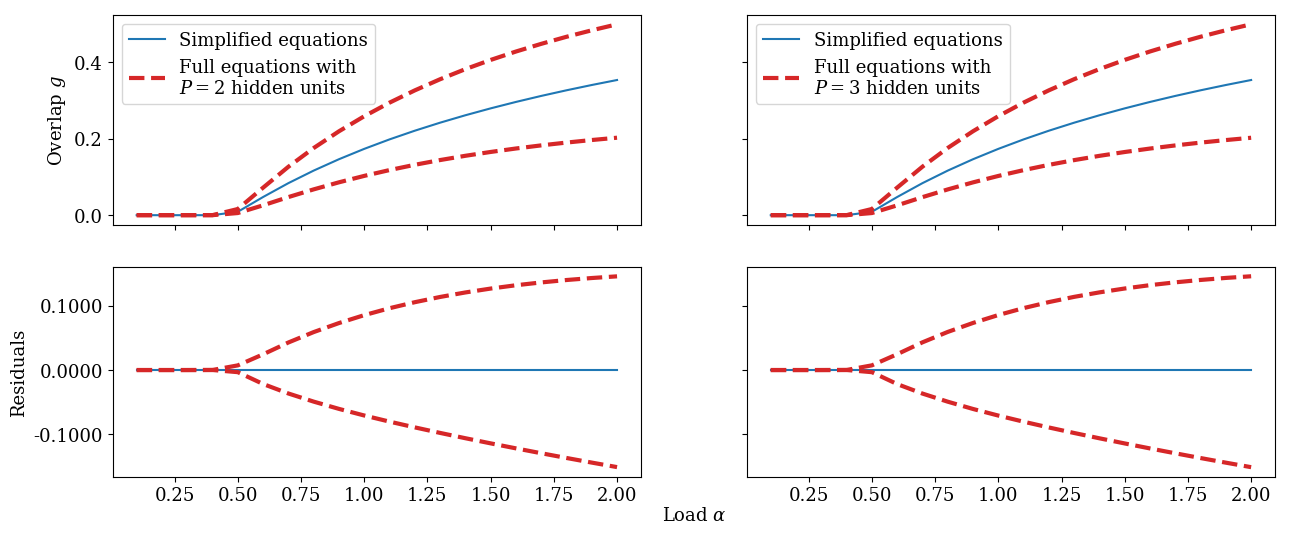

In [26]:
n_alpha = 20

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

beta = 1.2
P_range = np.array([2, 3])

fig, (m_main_axes, m_res_axes) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = "row", figsize = (15, 6))
m_fig_axis = fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)

fig, (g_main_axes, g_res_axes) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = "row", figsize = (15, 6))
g_fig_axis = fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)

fontsize = 13

set_ylabel = True
for P, m_main_axis, m_res_axis, g_main_axis, g_res_axis in zip(P_range, m_main_axes, m_res_axes, g_main_axes, g_res_axes):
    with open("./Data/BM_unstructured_magnetization_P=%d_beta=%.2f.npy" % (P, beta), "rb") as file:
        m_comp_range = np.load(file)
        m_simp_range = np.load(file)
    
    with open("./Data/BM_unstructured_overlap_P=%d_beta=%.2f.npy" % (P, beta), "rb") as file:
        g_comp_range = np.load(file)
        g_simp_range = np.load(file)
    
    m_main_axis.plot(alpha_range, m_simp_range, linestyle = "-", color = "C0")
    m_main_axis.plot(alpha_range, m_comp_range, linestyle = "--", linewidth = 3, color = "C1")
    m_main_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    m_main_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    m_main_axis.legend([r"Simplified equations", r"Full equations with" + "\n" + r"$P = %d$ hidden units" % P], fontsize = fontsize)
    if set_ylabel:
        m_main_axis.set_ylabel(r"Magnetization $m$", fontsize = fontsize)
    
    m_res_axis.plot(alpha_range, np.zeros_like(alpha_range), linestyle = "-", color = "C0")
    m_res_axis.plot(alpha_range, m_comp_range - m_simp_range[:, np.newaxis], linestyle = "--", linewidth = 3, color = "C1")
    m_res_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    m_res_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    m_res_axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
    if set_ylabel:
        m_res_axis.set_ylabel(r"Residuals", fontsize = fontsize)
    
    g_main_axis.plot(alpha_range, g_simp_range, linestyle = "-", color = "C0")
    g_main_axis.plot(alpha_range, g_comp_range, linestyle = "--", linewidth = 3, color = "C3")
    g_main_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    g_main_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    g_main_axis.legend([r"Simplified equations", r"Full equations with" + "\n" + r"$P = %d$ hidden units" % P], fontsize = fontsize)
    if set_ylabel:
        g_main_axis.set_ylabel(r"Overlap $g$", fontsize = fontsize)

    g_res_axis.plot(alpha_range, np.zeros_like(alpha_range), linestyle = "-", color = "C0")
    g_res_axis.plot(alpha_range, g_comp_range - g_simp_range[:, np.newaxis], linestyle = "--", linewidth = 3, color = "C3")
    g_res_axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
    g_res_axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
    g_res_axis.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4f'))
    if set_ylabel:
        g_res_axis.set_ylabel(r"Residuals", fontsize = fontsize)
    
    set_ylabel = False

m_fig_axis.set_xlabel(r"Load $\alpha$", fontsize = fontsize)
g_fig_axis.set_xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.show()

In [21]:
n_alpha = 20

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

m_comp_range = np.zeros(n_alpha)
m_simp_range = np.zeros(n_alpha)

g_comp_range = np.zeros(n_alpha)
g_simp_range = np.zeros(n_alpha)

n_normal_samples = 8000000
n_binary_samples = 80000000
n_simple_samples = 401
t = 100
t_step = 1/2
t_simple = 50
seed = 4
key = jax.random.PRNGKey(seed)
tol = machine_eps
m_0 = 0.1
epsilon = 0.01

beta_s = 1.2
beta = 1.2
alpha = 0
P = 3
P_t = 4
c = 0

mat_cor = mat_equi_cor(c, P)

iterator = NormalIterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

simple_iterator = SimpleNormalIterator(n_simple_samples)

m_init = (m_0 - epsilon)*np.eye(P, P_t) + epsilon
s_init = (1 - epsilon)*np.eye(P_t) + epsilon
q_init = (m_0 - epsilon)*np.eye(P_t) + epsilon

m_simp_init = 0.1
g_simp_init = 0.1

for j, alpha in enumerate(alpha_range):
    m, s, q, _ = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
    
    m_comp_range[j] = np.mean(np.diagonal(m))
    if P_t > P:
        g_comp_range[j] = np.mean(np.diagonal(q)[P : P_t])
    
    m, g = simple_iterator.iterate(t_simple, beta, alpha, m_simp_init, g_simp_init)
    m_simp_range[j] = np.squeeze(m)
    if P_t > P:
        g_simp_range[j] = np.squeeze(g)

with open("./Data/BM_normal_uncorrelated_magnetization_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, m_comp_range)
    np.save(file, m_simp_range)

with open("./Data/BM_normal_uncorrelated_overlap_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, g_comp_range)
    np.save(file, g_simp_range)

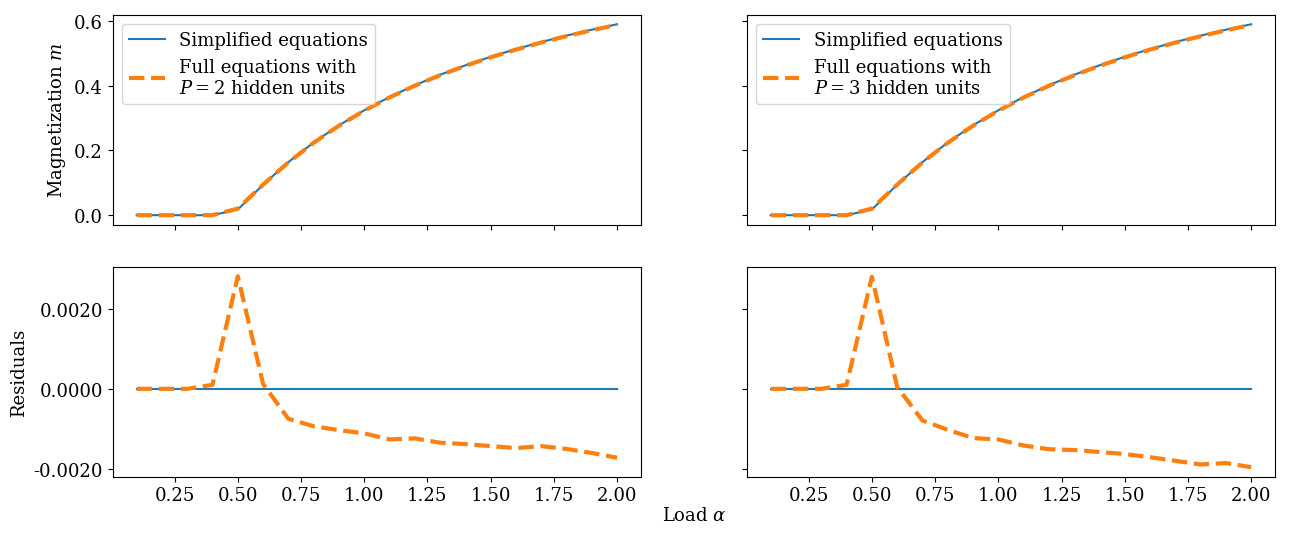

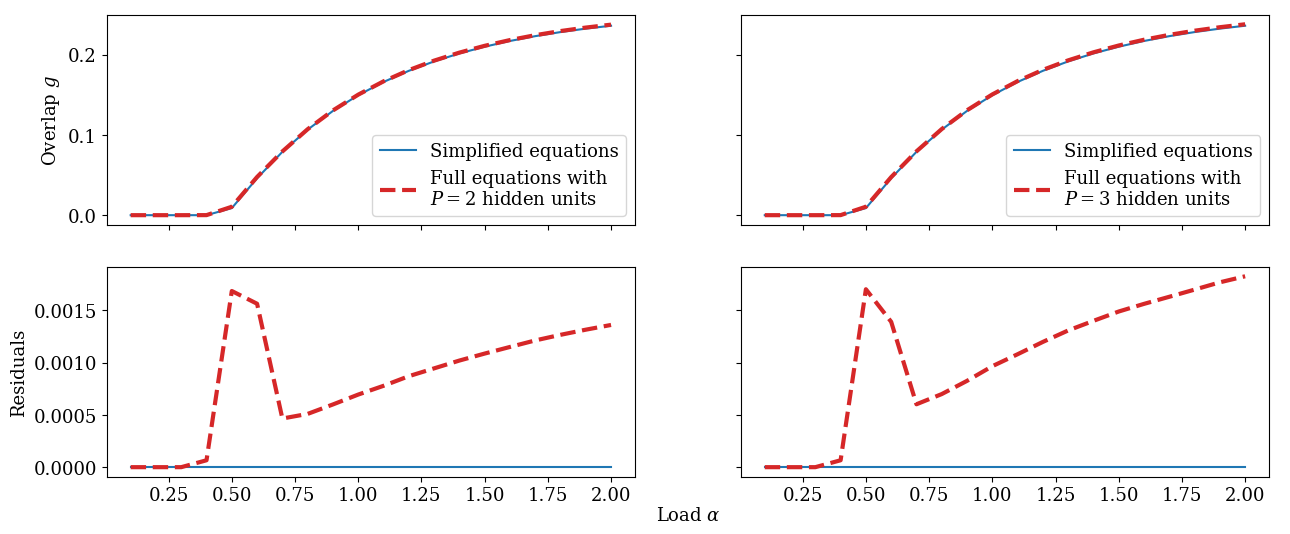

In [23]:
n_alpha = 20
alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

beta = 1.2

P_range = np.array([2, 3])

name = "normal_uncorrelated"

plot_overlap(beta, alpha_range, P_range, name)

### Test against simulations

In [46]:
n_alpha = 20

alpha_range = np.linspace(0.1, 1, num = n_alpha, endpoint = True)

m_comp_range = np.zeros((n_alpha, 2))
m_simp_range = np.zeros(n_alpha)

g_comp_range = np.zeros((n_alpha, 2))
g_simp_range = np.zeros(n_alpha)

n_normal_samples = 8000000
n_binary_samples = 80000000
n_simple_samples = 401
t = 10000
t_step = 0.05
t_simple = 500
seed = 4
key = jax.random.PRNGKey(seed)
tol = machine_eps
m_0 = 0.2
epsilon = 0

beta_s = 4 # 1.2
beta = 4 # 1.2
alpha = 0
P = 2
P_t = P + 1
c = 0

mat_cor = mat_equi_cor(c, P)

iterator = NormalIterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

simple_iterator = SimpleNormalIterator(n_simple_samples)

m_init = (m_0 - epsilon)*np.eye(P, P_t) + epsilon
s_init = (1 - epsilon)*np.eye(P_t) + epsilon
m_init[0, P] = m_0
q_init = (m_0 - epsilon)*np.eye(P_t) + epsilon

m_simp_init = 0.1
g_simp_init = 0.1

for j, alpha in enumerate(alpha_range):
    m, s, q, _ = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
    
    m_comp_range[j, 0] = np.mean(np.diagonal(m)[1 :])
    m_comp_range[j, 1] = (m[0, 0] + m[0, P])/2
    if P_t > P:
        g_comp_range[j, 0] = (q[0, 0] + q[P_t, P_t])/2
        g_comp_range[j, 1] = (q[0, P_t] + q[P_t, 0])/2
    
    m, g = simple_iterator.iterate(t_simple, beta, alpha, m_simp_init, g_simp_init)
    m_simp_range[j] = np.squeeze(m)
    if P_t > P:
        g_simp_range[j] = np.squeeze(g)

with open("./Data/BM_normal_uncorrelated_magnetization_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, m_comp_range)
    np.save(file, m_simp_range)

with open("./Data/BM_normal_uncorrelated_overlap_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, g_comp_range)
    np.save(file, g_simp_range)

0.9411675288015333
[[ 5.5243587e-01  2.9644994e-08  6.4057991e-02]
 [ 2.9644992e-08  9.9997872e-01 -2.8087815e-08]
 [ 6.4057969e-02 -2.8087815e-08  5.5244505e-01]]
[[ 3.0785337e-01  2.8483171e-08  2.7544707e-01]
 [ 2.8483175e-08  9.4055146e-01 -2.6944187e-08]
 [ 2.7544704e-01 -2.6944187e-08  3.0786392e-01]]
[0.94056141 0.51933968]


FileNotFoundError: [Errno 2] No such file or directory: './Data/BM_normal_uncorrelated_magnetization_P=3_beta=4.00.npy'

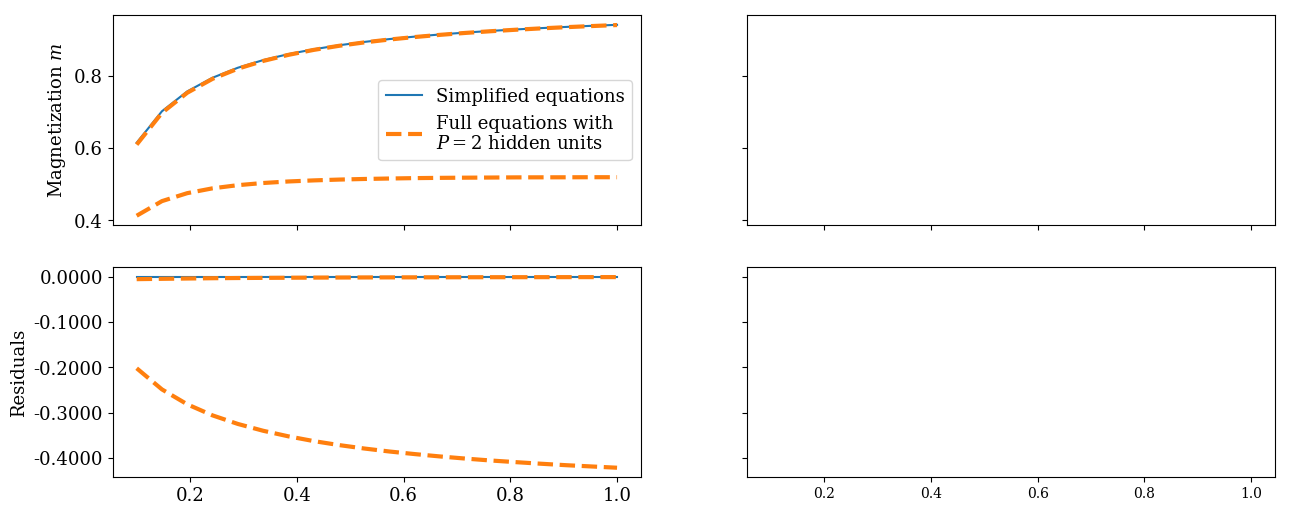

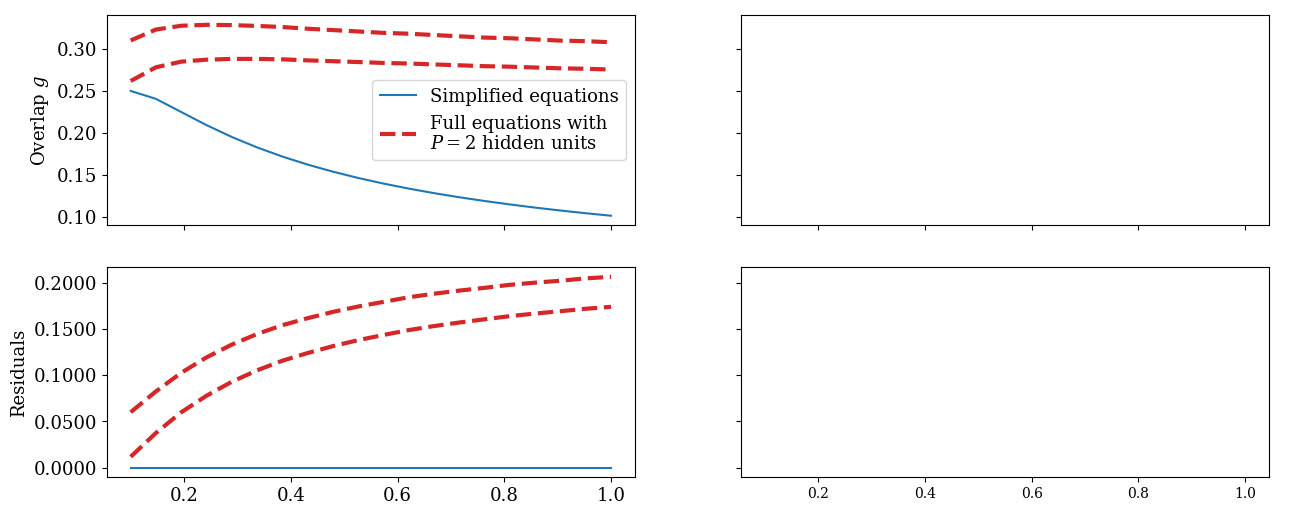

In [47]:
print(m)
print(s)
print(q)

n_alpha = 20
alpha_range = np.linspace(0.1, 1, num = n_alpha, endpoint = True)

beta = 4

P_range = np.array([2, 3])

name = "normal_uncorrelated"

plot_overlap(beta, alpha_range, P_range, name)

In [31]:
print(m_comp[-1])

NameError: name 'm_comp' is not defined

In [21]:
n_alpha = 20

alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

m_comp_range = np.zeros((n_alpha, 2))
m_simp_range = np.zeros(n_alpha)

g_comp_range = np.zeros((n_alpha, 2))
g_simp_range = np.zeros(n_alpha)

n_normal_samples = 8000000
n_binary_samples = 80000000
n_simple_samples = 401
t = 100
t_step = 1/2
t_simple = 50
seed = 4
key = jax.random.PRNGKey(seed)
tol = machine_eps
m_0 = 0.2
epsilon = 0

beta_s = 1.2
beta = 1.2
alpha = 0
P = 2
P_t = P + 1
c = 0

mat_cor = mat_equi_cor(c, P)

iterator = NormalIterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

simple_iterator = SimpleNormalIterator(n_simple_samples)

m_init = (m_0 - epsilon)*np.eye(P, P_t) + epsilon
s_init = (1 - epsilon)*np.eye(P_t) + epsilon
m_init[0, P] = m_0
q_init = (m_0 - epsilon)*np.eye(P_t) + epsilon

m_simp_init = 0.1
g_simp_init = 0.1

for j, alpha in enumerate(alpha_range):
    m, s, q, _ = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
    # print(m)
    # print(q)
    # print(s)
    m_comp_range[j, 0] = np.mean(np.diagonal(m)[1 :])
    m_comp_range[j, 1] = (m[0, 0] + m[0, P])/2
    if P_t > P:
        g_comp_range[j, 0] = (q[0, 0] + q[P_t, P_t])/2 # np.mean(np.diagonal(q)[P : P_t])
        g_comp_range[j, 1] = (q[0, P_t] + q[P_t, 0])/2
    
    m, g = simple_iterator.iterate(t_simple, beta, alpha, m_simp_init, g_simp_init)
    m_simp_range[j] = np.squeeze(m)
    if P_t > P:
        g_simp_range[j] = np.squeeze(g)

with open("./Data/BM_normal_unstructured_magnetization_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, m_comp_range)
    np.save(file, m_simp_range)

with open("./Data/BM_normal_unstructured_overlap_P=%d_beta=%.2f.npy" % (P, beta), "wb") as file:
    np.save(file, g_comp_range)
    np.save(file, g_simp_range)

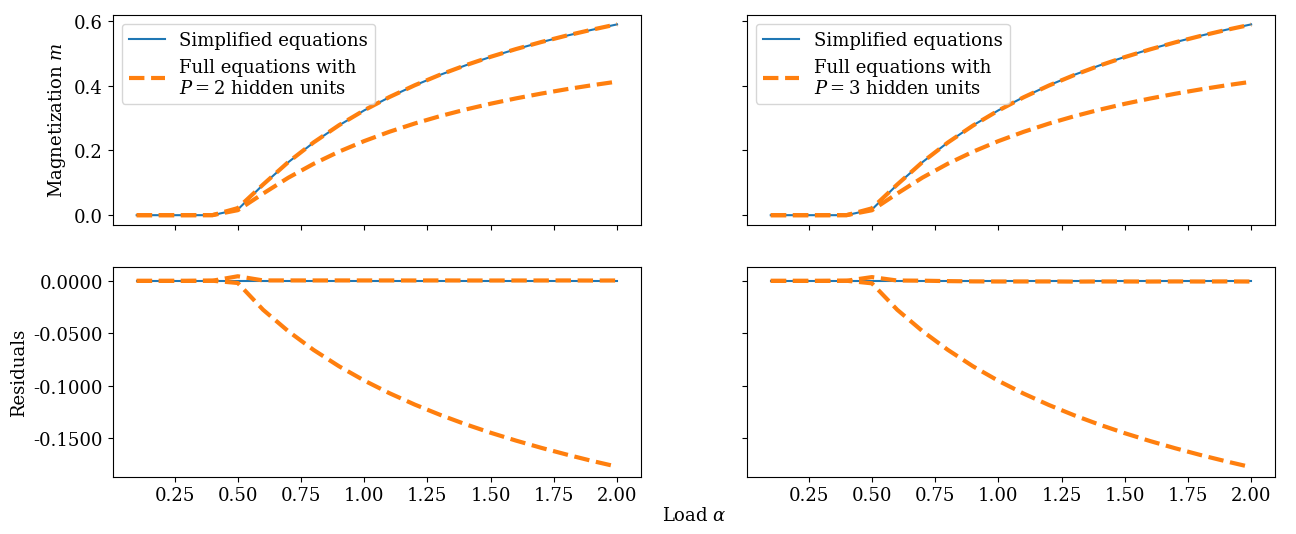

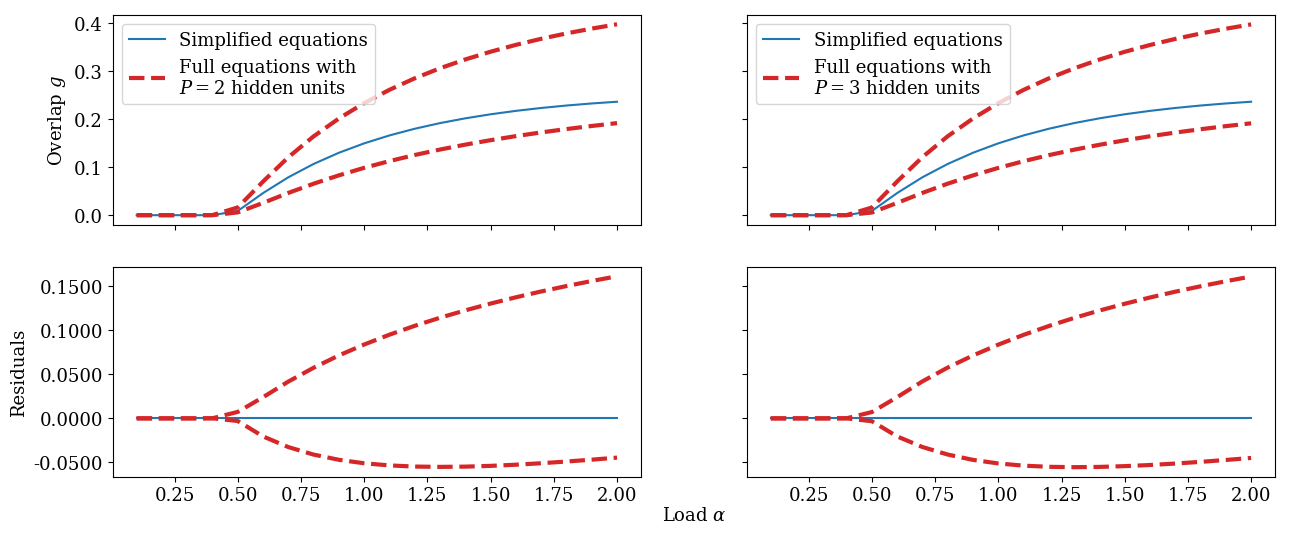

In [22]:
n_alpha = 20
alpha_range = np.linspace(0.1, 2, num = n_alpha, endpoint = True)

beta = 1.2

P_range = np.array([2, 3])

name = "normal_unstructured"

plot_overlap(beta, alpha_range, P_range, name)

### Anchor

In [ ]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

m_range = np.zeros((n_beta, n_alpha))
eigval_range = np.zeros(n_beta)

n_normal_samples = 8000000
n_binary_samples = 80000000
t = 100
t_step = 1/2
seed = 4
key = jax.random.PRNGKey(seed)
tol = machine_eps

beta_s = 0
beta = 0
alpha = 0
P = 2
P_t = 2
c = 0.7

mat_cor = mat_equi_cor(c, P)

iterator = Iterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

# raise NotImplementedError

m_init = jnp.eye(P, P_t)
s_init = jnp.eye(P_t)
q_init = jnp.eye(P_t)

for i, T in enumerate(T_range):
    for j, alpha in enumerate(alpha_range):
        beta_s = 1/T
        beta = 1/T
        
        m, s, q, p_M_s = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
        
        m_range[i, j] = np.mean(np.diagonal(m))
    
    d = np.squeeze(np.sum(p_M_s * iterator.spins_s_T * iterator.spins_s, axis = 0))[0, 1]
    eigval = (P - 1)**2 * c*d + (P - 1) * (c + d) + 1
    eigval_range[i] = eigval

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0, vmax = 0.75)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

with open("./Data/BM_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "wb") as file:
    np.save(file, m_range)
    np.save(file, eigval_range)

In [ ]:
with open("./Data/BM_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "wb") as file:
    np.save(file, m_range)
    np.save(file, eigval_range)

In [ ]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

P = 2
c = 0.7

with open("./Data/BM_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
    m_range = np.load(file)
    eigval_range = np.load(file)

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0, vmax = 0.75)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
plt.show()

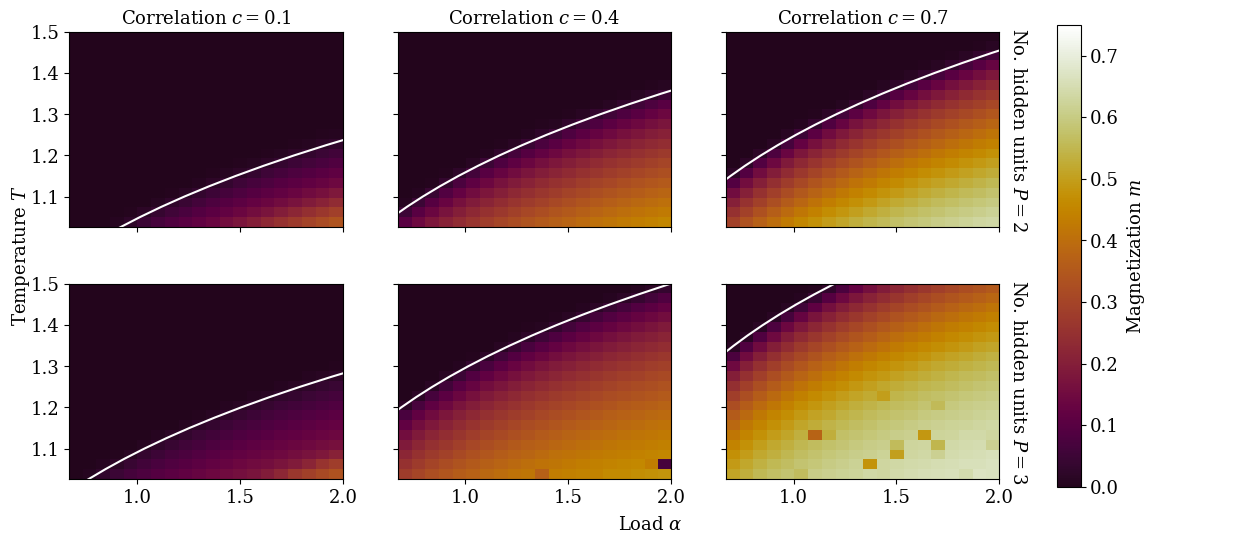

In [34]:
P_range = np.array([2, 3])

n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)
c_range = np.array([0.1, 0.4, 0.7])

fig, axes = plt.subplots(len(P_range), 3, sharex = True, sharey = True, figsize = (15, 6))
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
fontsize = 13

for i, P in enumerate(P_range):
    for c, axis in zip(c_range, axes[i]):
        with open("./Data/BM_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
            m_range = np.load(file)
            eigval_range = np.load(file)
        
        image = axis.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
                            extent = (np.min(alpha_range), np.max(alpha_range),
                                      np.min(T_range), np.max(T_range)),
                            vmin = 0, vmax = 0.75)
        axis.plot(T_range**4/eigval_range, T_range, color = "white")
        axis.set_xlim(np.min(alpha_range), np.max(alpha_range))
        axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        if i == 0:
            axis.set_title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
        
    axis.set_ylabel(r"No. hidden units $P = %d$" % P, fontsize = fontsize, rotation = -90, labelpad = 20)
    axis.yaxis.set_label_position("right")

colorbar = plt.colorbar(image, ax = axes.ravel().tolist())
colorbar.ax.tick_params(labelsize = fontsize)
colorbar.set_label(r"Magnetization $m$", fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

In [ ]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

m_range = np.zeros((n_beta, n_alpha))
eigval_range = np.zeros(n_beta)

n_normal_samples = 8000000
n_binary_samples = 80000000
t = 100
t_step = 1/2
seed = 1
key = jax.random.PRNGKey(seed)
key_init, key = jax.random.split(key, num = 2)
tol = machine_eps

beta_s = 0
beta = 0
alpha = 0
P = 3
P_t = 3
c = 0.1

mat_cor_cor = mat_equi_cor(c, P)
mat_cor = np.squeeze(random_mat_cor(mat_cor_cor, P, 1, 1, key_init))

iterator = Iterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

m_init = jnp.eye(P, P_t)
s_init = jnp.eye(P_t)
q_init = jnp.eye(P_t)

for i, T in enumerate(T_range):
    for j, alpha in enumerate(alpha_range):
        beta_s = 1/T
        beta = 1/T
        
        m, s, q, p_M_s = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
        
        m_range[i, j] = np.mean(np.diagonal(m))
    
    hidden_cor = jnp.sum(p_M_s * iterator.spins_s_T * iterator.spins_s, axis = 0)
    
    eigval = jnp.max(jnp.linalg.eigh(hidden_cor @ mat_cor)[0], axis = -1)
    eigval_range[i] = eigval

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0, vmax = 0.75)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

with open("./Data/BM_random_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "wb") as file:
    np.save(file, m_range)
    np.save(file, eigval_range)

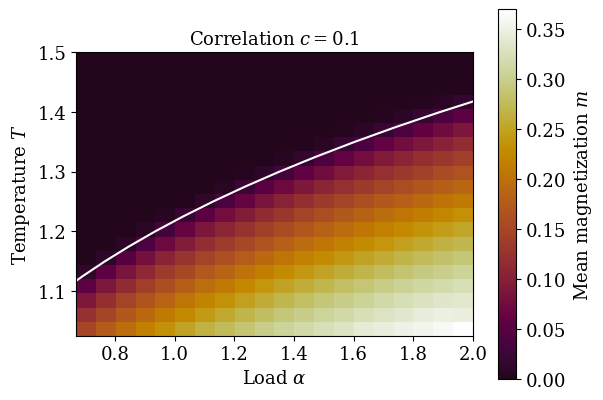

In [21]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

P = 3
c = 0.1

with open("./Data/BM_random_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
    m_range = np.load(file)
    eigval_range = np.load(file)

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
plt.show()

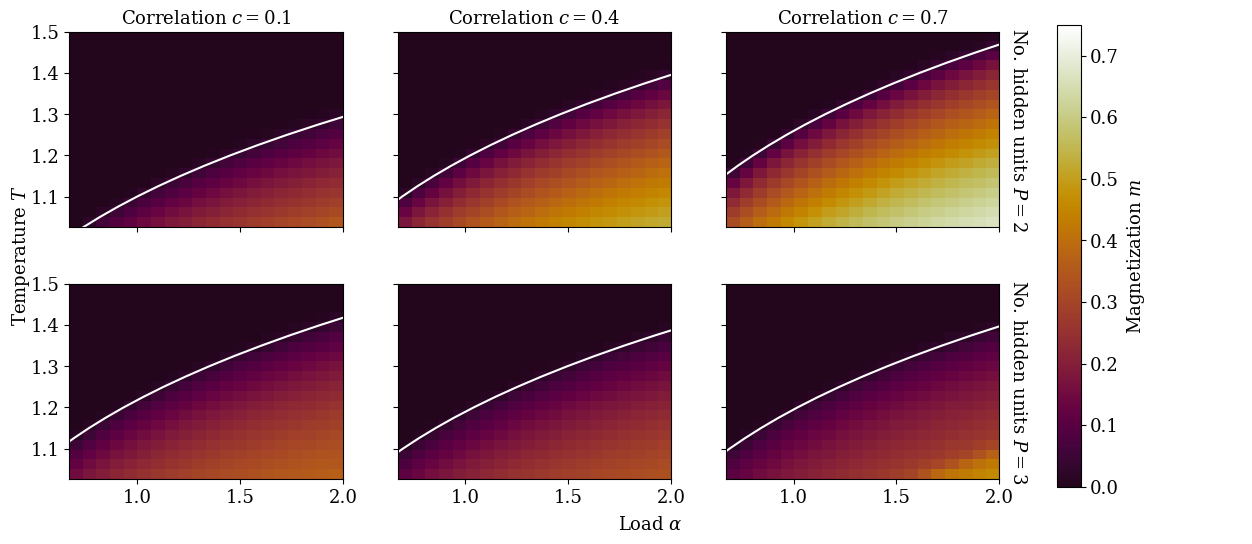

In [21]:
P_range = np.array([2, 3])

n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)
c_range = np.array([0.1, 0.4, 0.7])

fig, axes = plt.subplots(len(P_range), 3, sharex = True, sharey = True, figsize = (15, 6))
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
fontsize = 13

for i, P in enumerate(P_range):
    for c, axis in zip(c_range, axes[i]):
        with open("./Data/BM_random_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
            m_range = np.load(file)
            eigval_range = np.load(file)
        
        image = axis.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
                            extent = (np.min(alpha_range), np.max(alpha_range),
                                      np.min(T_range), np.max(T_range)),
                            vmin = 0, vmax = 0.75)
        axis.plot(T_range**4/eigval_range, T_range, color = "white")
        axis.set_xlim(np.min(alpha_range), np.max(alpha_range))
        axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        if i == 0:
            axis.set_title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
        
    axis.set_ylabel(r"No. hidden units $P = %d$" % P, fontsize = fontsize, rotation = -90, labelpad = 20)
    axis.yaxis.set_label_position("right")

colorbar = plt.colorbar(image, ax = axes.ravel().tolist())
colorbar.ax.tick_params(labelsize = fontsize)
colorbar.set_label(r"Magnetization $m$", fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

### Normal weights

In [ ]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

m_range = np.zeros((n_beta, n_alpha))
eigval_range = np.zeros(n_beta)

n_normal_samples = 8000000
n_binary_samples = 80000000
t = 100
t_step = 1/2
seed = 4
key = jax.random.PRNGKey(seed)
tol = machine_eps

beta_s = 0
beta = 0
alpha = 0
P = 3
P_t = 3
c = 0.7

mat_cor = mat_equi_cor(c, P)

iterator = NormalIterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

# raise NotImplementedError

m_init = jnp.eye(P, P_t)
s_init = jnp.eye(P_t)
q_init = jnp.eye(P_t)

for i, T in enumerate(T_range):
    for j, alpha in enumerate(alpha_range):
        beta_s = 1/T
        beta = 1/T
        
        m, s, q, p_M_s = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
        
        m_range[i, j] = np.mean(np.diagonal(m))
    
    d = np.squeeze(np.sum(p_M_s * iterator.spins_s_T * iterator.spins_s, axis = 0))[0, 1]
    eigval = (P - 1)**2 * c*d + (P - 1) * (c + d) + 1
    eigval_range[i] = eigval

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0, vmax = 0.75)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

with open("./Data/BM_normal_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "wb") as file:
    np.save(file, m_range)
    np.save(file, eigval_range)

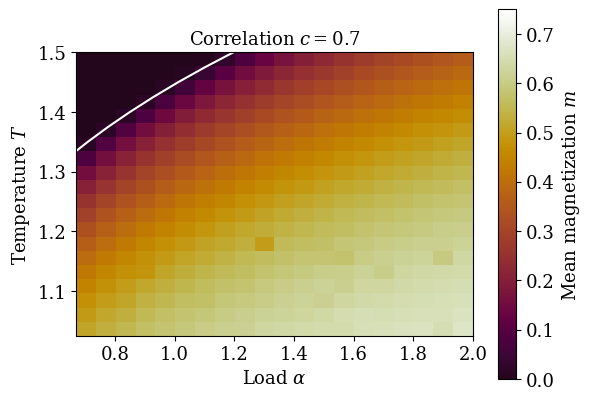

In [25]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

P = 3
c = 0.7

with open("./Data/BM_normal_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
    m_range = np.load(file)
    eigval_range = np.load(file)

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0, vmax = 0.75)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
plt.show()

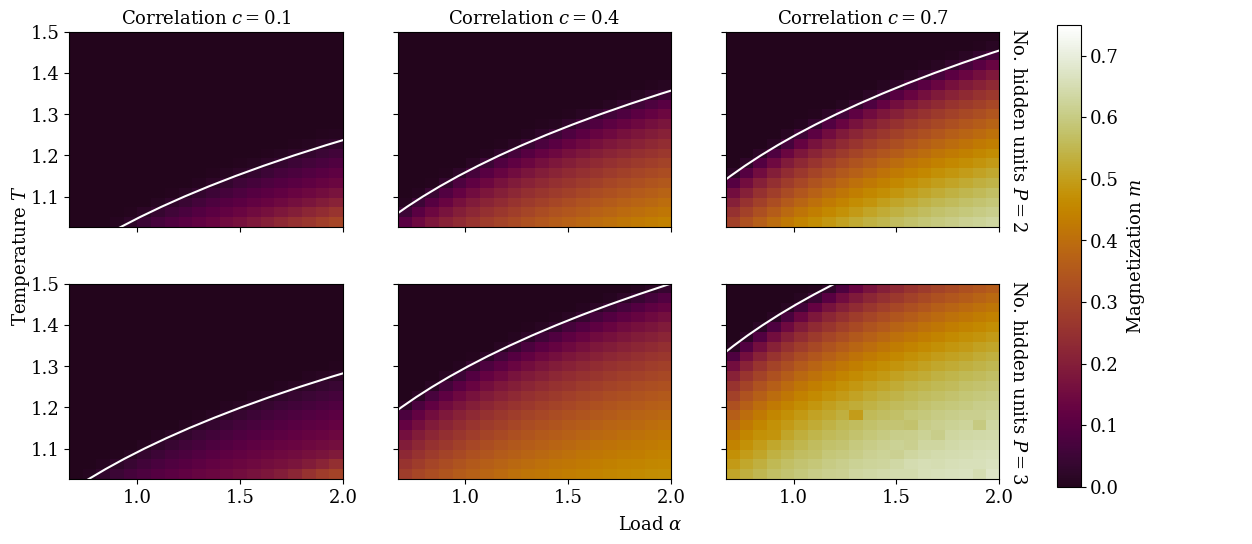

In [26]:
P_range = np.array([2, 3])

n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)
c_range = np.array([0.1, 0.4, 0.7])

fig, axes = plt.subplots(len(P_range), 3, sharex = True, sharey = True, figsize = (15, 6))
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
fontsize = 13

for i, P in enumerate(P_range):
    for c, axis in zip(c_range, axes[i]):
        with open("./Data/BM_normal_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
            m_range = np.load(file)
            eigval_range = np.load(file)
        
        image = axis.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
                            extent = (np.min(alpha_range), np.max(alpha_range),
                                      np.min(T_range), np.max(T_range)),
                            vmin = 0, vmax = 0.75)
        axis.plot(T_range**4/eigval_range, T_range, color = "white")
        axis.set_xlim(np.min(alpha_range), np.max(alpha_range))
        axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        if i == 0:
            axis.set_title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
        
    axis.set_ylabel(r"No. hidden units $P = %d$" % P, fontsize = fontsize, rotation = -90, labelpad = 20)
    axis.yaxis.set_label_position("right")

colorbar = plt.colorbar(image, ax = axes.ravel().tolist())
colorbar.ax.tick_params(labelsize = fontsize)
colorbar.set_label(r"Magnetization $m$", fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

In [ ]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

m_range = np.zeros((n_beta, n_alpha))
eigval_range = np.zeros(n_beta)

n_normal_samples = 8000000
n_binary_samples = 80000000
t = 100
t_step = 1/2
seed = 1
key = jax.random.PRNGKey(seed)
key_init, key = jax.random.split(key, num = 2)
tol = machine_eps

beta_s = 0
beta = 0
alpha = 0
P = 3
P_t = 3
c = 0.1

mat_cor_cor = mat_equi_cor(c, P)
mat_cor = np.squeeze(random_mat_cor(mat_cor_cor, P, 1, 1, key_init))

iterator = NormalIterator(mat_cor, P, P_t, n_normal_samples, n_binary_samples, key, tol)

m_init = jnp.eye(P, P_t)
s_init = jnp.eye(P_t)
q_init = jnp.eye(P_t)

for i, T in enumerate(T_range):
    for j, alpha in enumerate(alpha_range):
        beta_s = 1/T
        beta = 1/T
        
        m, s, q, p_M_s = iterator.iterate(t, t_step, beta_s, beta, alpha, m_init, s_init, q_init)
        
        m_range[i, j] = np.mean(np.diagonal(m))
    
    hidden_cor = jnp.sum(p_M_s * iterator.spins_s_T * iterator.spins_s, axis = 0)
    
    eigval = jnp.max(jnp.linalg.eigh(hidden_cor @ mat_cor)[0], axis = -1)
    eigval_range[i] = eigval

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0, vmax = 0.75)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

with open("./Data/BM_normal_random_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "wb") as file:
    np.save(file, m_range)
    np.save(file, eigval_range)

In [23]:
n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)

P = 3
c = 0.1

with open("./Data/BM_normal_random_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
    m_range = np.load(file)
    eigval_range = np.load(file)

fontsize = 13

plt.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
           extent = (np.min(alpha_range), np.max(alpha_range),
                     np.min(T_range), np.max(T_range)),
           vmin = 0)
plt.plot(T_range**4/eigval_range, T_range, color = "white")
plt.xlim(np.min(alpha_range), np.max(alpha_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Mean magnetization $m$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Data/BM_normal_random_phase_diagram_P=3_c=0.10.npy'

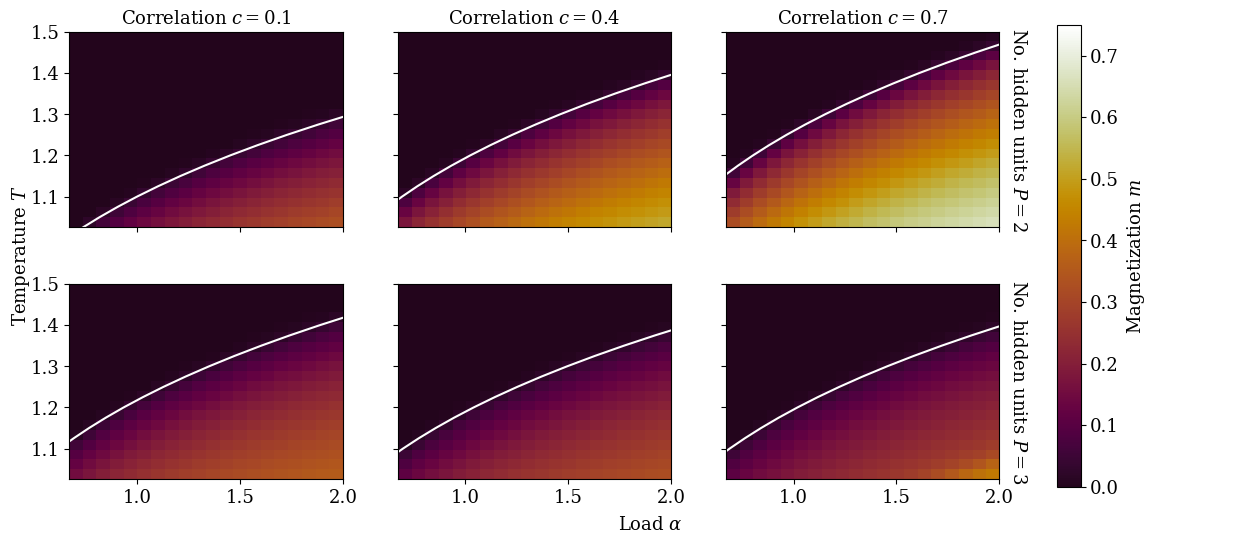

In [25]:
P_range = np.array([2, 3])

n_beta = 20
n_alpha = 20

T_range = np.linspace(1.025, 1.5, num = n_beta, endpoint = True)
alpha_range = np.linspace(0.67, 2, num = n_alpha, endpoint = True)
c_range = np.array([0.1, 0.4, 0.7])

fig, axes = plt.subplots(len(P_range), 3, sharex = True, sharey = True, figsize = (15, 6))
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
fontsize = 13

for i, P in enumerate(P_range):
    for c, axis in zip(c_range, axes[i]):
        with open("./Data/BM_normal_random_phase_diagram_P=%d_c=%.2f.npy" % (P, c), "rb") as file:
            m_range = np.load(file)
            eigval_range = np.load(file)
        
        image = axis.imshow(m_range, aspect = 2, origin = "lower", cmap = cmr.fall,
                            extent = (np.min(alpha_range), np.max(alpha_range),
                                      np.min(T_range), np.max(T_range)),
                            vmin = 0, vmax = 0.75)
        axis.plot(T_range**4/eigval_range, T_range, color = "white")
        axis.set_xlim(np.min(alpha_range), np.max(alpha_range))
        axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        if i == 0:
            axis.set_title(r"Correlation $c = %.1f$" % c, fontsize = fontsize)
        
    axis.set_ylabel(r"No. hidden units $P = %d$" % P, fontsize = fontsize, rotation = -90, labelpad = 20)
    axis.yaxis.set_label_position("right")

colorbar = plt.colorbar(image, ax = axes.ravel().tolist())
colorbar.ax.tick_params(labelsize = fontsize)
colorbar.set_label(r"Magnetization $m$", fontsize = fontsize)
plt.xlabel(r"Load $\alpha$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

### Plot $\alpha_{\mathrm{crit}}$ as a function of $P$, $c$ and $T$.

In [ ]:
n_beta = 400
n_c = 400

T_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
beta_s_range = 1/T_range[:, np.newaxis, np.newaxis, np.newaxis]
c_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

# inv_eigval_range = np.zeros((n_beta, n_c))

P = 6

seed = 4
key = jax.random.PRNGKey(seed)

mat_cor = mat_equi_cor(c_range[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis], P)

spins_s_T, spins_s = init_spins(P, n_pre_appended_axes = 2)

H_M_s = hamiltonian_M(spins_s_T, spins_s, mat_cor, beta_s_range)
p_M_s = probability(H_M_s)

d_range = jnp.squeeze(jnp.sum(p_M_s * spins_s_T * spins_s, axis = 0))[..., 0, 1]
eigval_range = (P - 1)**2 * c_range*d_range + (P - 1) * (c_range + d_range) + 1

inv_eigval_range = 1/eigval_range

fontsize = 13

plt.contourf(c_range, T_range, inv_eigval_range, origin = "lower", cmap = "viridis", levels = 8)
plt.xlim(np.min(c_range), np.max(c_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Inverse eigenvalue $1 / \lambda^{\mathcal{S}}_{\mathrm{max}}$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Number of hidden units $P = %d$" % P)
plt.show()

with open("./Data/BM_inv_eigval_range_P=%d.npy" % P, "wb") as file:
    np.save(file,inv_eigval_range)

In [ ]:
n_beta = 400
n_c = 400

T_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
c_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

P = 6

with open("./Data/BM_inv_eigval_range_P=%d.npy" % P, "rb") as file:
    inv_eigval_range = np.load(file)

fontsize = 13

plt.contourf(c_range, T_range, inv_eigval_range, origin = "lower", cmap = "viridis", levels = 8)
# plt.contourf(c_range, T_range, T_range[:, np.newaxis]**4/eigval_range, origin = "lower", cmap = "viridis", levels = 16)
plt.xlim(np.min(c_range), np.max(c_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Inverse eigenvalue $1 / \lambda^{\mathcal{S}}_{\mathrm{max}}$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Number of hidden units $P = %d$" % P)
plt.show()

In [ ]:
n_beta = 400
n_c = 400

T_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
c_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

P = 2

with open("./Data/BM_inv_eigval_range_P=%d.npy" % P, "rb") as file:
    inv_eigval_range = np.load(file)

fontsize = 13

n_levels = 16

alpha_crit = T_range[:, np.newaxis]**4*inv_eigval_range

# levels = np.sort(np.ravel(alpha_crit**(1/4)))
# levels = levels[: : len(levels)//16]**4
levels = 10.**np.arange(-16, 1, 1)

# plt.imshow(eigval_range, aspect = 2, origin = "lower", cmap = "viridis",
           # extent = (np.min(c_range), np.max(c_range),
                     # np.min(T_range), np.max(T_range)))
plt.contourf(c_range, T_range, alpha_crit, origin = "lower", cmap = "viridis", levels = levels, norm = colors.LogNorm())
plt.xlim(np.min(c_range), np.max(c_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Critical load $\alpha_{\mathrm{crit}}$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Number of hidden units $P = %d$" % P)
plt.show()

In [ ]:
n_beta = 20
n_c = 20

T_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)

beta_s_range = 1/T_range[:, np.newaxis, np.newaxis, np.newaxis]

c_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

inv_eigval_range = np.zeros((n_beta, n_c))

P = 2
t = 1000000

seed = 4
key = jax.random.PRNGKey(seed)

mat_cor_cor = mat_equi_cor(c_range[np.newaxis, :, jnp.newaxis, jnp.newaxis, jnp.newaxis], P)

spins_s_T, spins_s = init_spins(P, n_pre_appended_axes = 2)

inv_eigval_range, key = jax.lax.fori_loop(0, t, partial(accumulate_inv_eigvals, spins_s_T, spins_s, mat_cor_cor, beta_s_range, P, n_beta, n_c),
                                          (inv_eigval_range, key))

fontsize = 13

# plt.imshow(eigval_range, aspect = 2, origin = "lower", cmap = "viridis",
           # extent = (np.min(c_range), np.max(c_range),
                     # np.min(T_range), np.max(T_range)))
plt.contourf(c_range, T_range, inv_eigval_range, origin = "lower", cmap = "viridis", levels = 8)
plt.xlim(np.min(c_range), np.max(c_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Inverse eigenvalue $1 / \lambda^{\mathcal{S}}_{\mathrm{max}}$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Number of hidden units $P = %d$" % P)
plt.show()

with open("./Data/BM_random_inv_eigval_range_P=%d.npy" % P, "wb") as file:
    np.save(file, inv_eigval_range)

In [ ]:
n_beta = 20
n_c = 20

T_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)

c_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

P = 6

with open("./Data/BM_random_inv_eigval_range_P=%d.npy" % P, "rb") as file:
    inv_eigval_range = np.load(file)

fontsize = 13

plt.contourf(c_range, T_range, inv_eigval_range, origin = "lower", cmap = "viridis", levels = 8)
plt.xlim(np.min(c_range), np.max(c_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Inverse eigenvalue $1 / \lambda^{\mathcal{S}}_{\mathrm{max}}$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Number of hidden units $P = %d$" % P)
plt.show()

In [ ]:
n_beta = 20
n_c = 20

T_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
c_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

P = 6

with open("./Data/BM_random_inv_eigval_range_P=%d.npy" % P, "rb") as file:
    inv_eigval_range = np.load(file)

fontsize = 13

levels = 10.**np.arange(-16, 1, 1)

plt.contourf(c_range, T_range, T_range[:, np.newaxis]**4*inv_eigval_range, origin = "lower", cmap = "viridis", levels = levels, norm = colors.LogNorm())
plt.xlim(np.min(c_range), np.max(c_range))
colorbar = plt.colorbar()
colorbar.ax.tick_params(axis = "both", which = "minor", labelsize = fontsize)
colorbar.ax.tick_params(axis = "both", which = "major", labelsize = fontsize)
colorbar.set_label(r"Critical load $\alpha_{\mathrm{crit}}$", fontsize = fontsize)
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.title(r"Number of hidden units $P = %d$" % P)
plt.show()

In [ ]:
n_beta = 400
n_c = 400

T_equi_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
c_equi_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

n_beta = 20
n_c = 20

T_rand_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
c_rand_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

file_name_list = ["BM_inv_eigval_range", "BM_random_inv_eigval_range"]
c_range_list = [c_equi_range, c_rand_range]
T_range_list = [T_equi_range, T_rand_range]
row_label_list = [r"Uniform correlations", r"Random correlations"]

P_range = np.array([2, 4, 6])

fig, axes = plt.subplots(2, 3, sharex = True, sharey = True, figsize = (15, 6))
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
fontsize = 13

for i in range(2):
    for P, axis in zip(P_range, axes[i]):
        file_name = file_name_list[i]
        c_range = c_range_list[i]
        T_range = T_range_list[i]
        row_label = row_label_list[i]
        
        with open("./Data/%s_P=%d.npy" % (file_name, P), "rb") as file:
            inv_eigval_range = np.load(file)
    
        image = axis.contourf(c_range, T_range, 1/inv_eigval_range, origin = "lower", cmap = "viridis", levels = 8)
        axis.set_xlim(np.min(c_range), np.max(c_range))
        axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        
        colorbar = plt.colorbar(image, ax = axis)
        colorbar.ax.tick_params(labelsize = fontsize)
        colorbar.set_label(r"Largest eigenvalue $\lambda^{\mathcal{S}}_{\mathrm{max}}$", fontsize = fontsize)
        
        if i == 0:
            axis.set_title(r"No. hidden units $P = %d$" % P, fontsize = fontsize)
    
    axis.set_ylabel(row_label, fontsize = fontsize, rotation = -90, labelpad = 90)
    axis.yaxis.set_label_position("right")

plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

In [ ]:
n_beta = 400
n_c = 400

T_equi_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
c_equi_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

n_beta = 20
n_c = 20

T_rand_range = np.linspace(0.0025, 1, num = n_beta, endpoint = True)
c_rand_range = np.linspace(0, 0.95, num = n_c, endpoint = True)

file_name_list = ["BM_inv_eigval_range", "BM_random_inv_eigval_range"]
c_range_list = [c_equi_range, c_rand_range]
T_range_list = [T_equi_range, T_rand_range]
row_label_list = [r"Uniform correlations", r"Random correlations"]

P_range = np.array([2, 4, 6])

fig, axes = plt.subplots(2, 3, sharex = True, sharey = True, figsize = (15, 6))
fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)
fontsize = 13
levels = 10.**np.arange(-16, 1, 1)

for i in range(2):
    for P, axis in zip(P_range, axes[i]):
        file_name = file_name_list[i]
        c_range = c_range_list[i]
        T_range = T_range_list[i]
        row_label = row_label_list[i]
        
        with open("./Data/%s_P=%d.npy" % (file_name, P), "rb") as file:
            inv_eigval_range = np.load(file)
        
        alpha_crit = T_range[:, np.newaxis]**4*inv_eigval_range
        image =axis.contourf(c_range, T_range, alpha_crit, origin = "lower", cmap = "viridis", levels = levels, norm = colors.LogNorm())
        axis.set_xlim(np.min(c_range), np.max(c_range))
        axis.tick_params(axis = "both", which = "minor", labelsize = fontsize)
        axis.tick_params(axis = "both", which = "major", labelsize = fontsize)
        
        if i == 0:
            axis.set_title(r"No. hidden units $P = %d$" % P, fontsize = fontsize)
    
    axis.set_ylabel(row_label, fontsize = fontsize, rotation = -90, labelpad = 20)
    axis.yaxis.set_label_position("right")

colorbar = plt.colorbar(image, ax = axes.ravel().tolist())
colorbar.ax.tick_params(labelsize = fontsize)
colorbar.set_label(r"Critical load $\alpha_{\mathrm{crit}}$", fontsize = fontsize)
plt.xlabel(r"Correlation $c$", fontsize = fontsize)
plt.ylabel(r"Temperature $T$", fontsize = fontsize)
plt.show()

# $S = Q R$
# $\alpha_{\text{crit}} \leq \frac{1}{\beta^4 \lambda^S_{\text{max}}}$

### Plot unrelated probability distributions

In [ ]:
def prob(x, p):
    return np.exp(-x**p)

In [ ]:
fontsize = 13

x = np.linspace(-2, 2, num = 201, endpoint = True)
p_range = np.array([2, 4, 10])

for p in p_range:
    plt.plot(x, prob(x, p))
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    plt.title(r"$p = %d$" % p, fontsize = fontsize)
    plt.show()